In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import os 

# Downlaod and Save Resnet 50

- To use Resnet50 trained on imagenet as a base for our model, we downloaded it from keras and saved the model and its weights.

In [4]:
# This was downloaded and saved already and is not necessary anymore
save_resnet_50 = False

if save_resnet_50:
    resnet_50 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
    resnet_50.save("./models/resnet50")
    resnet_50.save_weights("./models/resnet50/checkpoints/")

# Preparing Image Augmentations

- We created subclasses of the keras.layers class. This way we can use these augmentations as layers of our models during traing and also use them to prepare the augmented testdata.   

In [5]:
class MotionBlur(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MotionBlur, self).__init__(**kwargs)
        
    def call(self, images, training=None):
        if not training:
            return images
        strength = 20 
        direction = randint(0, 1)
        if direction == 0: # 0 is horizontal, 1 is vertical
            kernel = np.zeros([3,strength]) 
            kernel[1] = 1/strength                                                                                                                                    
        else:
            kernel = np.zeros([strength,3]) 
            kernel[:,1] = 1/strength   
        kernel_motion_blur = tf.convert_to_tensor(kernel, tf.float32)
        kernel_motion_blur = tf.tile(kernel_motion_blur[..., None, None], [1,1,3,1])
        images = tf.nn.depthwise_conv2d(images, kernel_motion_blur, strides=(1,1,1,1), padding='SAME')
        return images

In [9]:
class GaussianBlur(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GaussianBlur, self).__init__(**kwargs)
        
    def call(self, images, training=None):
        if not training:
            return images

        images = tfa.image.gaussian_filter2d(images, filter_shape = (15,15), sigma = 30.5)
        return images

In [7]:
def noisy(images):
    out = []
    for image in images:
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        image = image + gauss
        image = tf.expand_dims(image, axis=0)
        out.append(image)
    return tf.concat(out, axis=0)

class GaussianNoise(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GaussianNoise, self).__init__(**kwargs)
        
    def call(self, images, training=None):
        if not training:
            return images

        images = noisy(images)
        return images

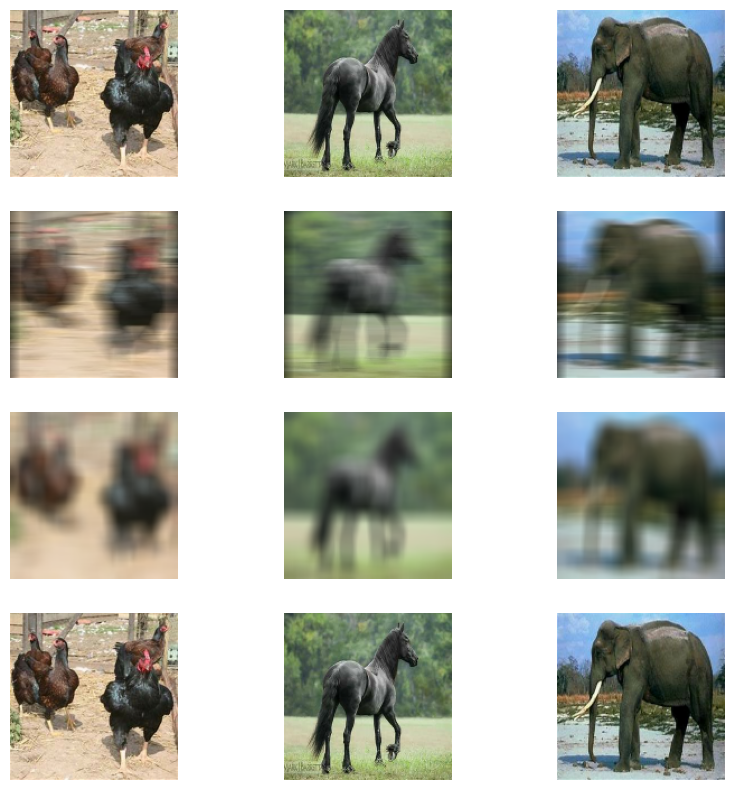

In [20]:
gblurlayer = GaussianBlur()
gnoiselayer = GaussianNoise()
mblurlayer = MotionBlur()


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  aug1 = mblurlayer(images, training=True)
  aug2 = gblurlayer(images, training=True)
  aug3 = gnoiselayer(images, training=True)
  for i in range(3):
    ax = plt.subplot(4, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")
    ax = plt.subplot(4, 3, i+4)
    plt.imshow(aug1[i].numpy().astype("uint8"))
    plt.axis("off")
    ax = plt.subplot(4, 3, i+7)
    plt.imshow(aug2[i].numpy().astype("uint8"))
    plt.axis("off")
    ax = plt.subplot(4, 3, i+10)
    plt.imshow(aug3[i].numpy().astype("uint8"))
    plt.axis("off")

# Create Test Data

- We used the Animal Image Classification Dataset from Kaggle. 
- After downloading the dataset, we selected the first 10% of images of each class and moved them to a folder exclusively used for testing. 



PIYUSHKUMAR.18. (n.d). Animal Image Classification Dataset, Version 1. Retrieved December 6 2022 from https://www.kaggle.com/datasets/piyushkumar18/animal-image-classification-dataset?datasetId=1112806

## Normal Test Data

- This is how we selected the first 10% images of each category and moved them to a different folder

In [3]:
# This code moved 10% of the images to a different folder and should not be run again
seperate_test_data = False

path = "./data/train/Animal Image Dataset/"

if seperate_test_data:
    d = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        d.extend(dirnames)
        break

    for folder in d:
        f = []
        c_path = f"{path}{folder}"
        for (dirpath, dirnames, filenames) in os.walk(c_path):
            f.extend(filenames)
            break
        for ff in f[0:len(f)//10]:
            #os.rename(f"{path}{folder}/{ff}", f"./data/test/normal_test_data/{folder}/{ff}") # this moves the files # this is commented out to reduce the risk of running this again 
            pass

## Augmented Test Data

- The following code creates augmented versions of the test data in individual folders. 

In [ ]:
# define the augmentations
augmentations = {
    "gblur": {"augmentation": None, "create": False},
    "gnoise": {"augmentation": None, "create": False},
    "mblur": {"augmentation": MotionBlur, "create": False}, # Already Created
    "expo": {"augmentation": None, "create": False},
    "jpgc": {"augmentation": None, "create": False},
    }

for aug in augmentations:
    folder_exists = os.path.exists(f"./data/test/{aug}_test_data")
    if not folder_exists:
        os.makedirs(f"./data/test/{aug}_test_data")

In [270]:
path = "./data/test/normal_test_data/"

d = []
for (dirpath, dirnames, filenames) in os.walk(path):
    d.extend(dirnames)
    break

for folder in d:
    print(f"> Creating augmented images for {folder}")
    f = []
    c_path = f"{path}{folder}"
    for (dirpath, dirnames, filenames) in os.walk(c_path):
        f.extend(filenames)
        break
    for ff in f:
        img = tf.keras.utils.load_img(f"{c_path}/{ff}")
        input_arr = tf.keras.utils.img_to_array(img)
        input_arr = np.array([input_arr])
        for aug in augmentations:
            if augmentations[aug]["create"]:
                folder_exists = os.path.exists(f"./data/test/{aug}_test_data/{folder}")
                if not folder_exists:
                    os.makedirs(f"./data/test/{aug}_test_data/{folder}")
                aug_layer = augmentations[aug]["augmentation"]()
                img_aug = aug_layer(input_arr, training=True)
                tf.keras.utils.save_img(f"./data/test/{aug}_test_data/{folder}/{aug}_{ff}", img_aug[0].numpy())

# Create Basic Model Template 

Basic Process
- We first trained the most basic model (i.e., resnet + flatten + dense[12]). 
- Afterwards we developed a more complex model architecture (i.e., resnet + maxpool2d + dropout + dense[24] + dense[12]) and compared its training statistics - train accuracy, train loss, validation accuracy, validation loss - with those from the most basic model.  
- The more complex model outperformed the basic model aand we used it as our base for tuning. 
- During tuning we systematically added additional architectural facets or varied existing hyperparameters, trained the new model, compared it with the previous model and repeated this process with the better performing model. 
- Because we want to investigate the generalizability of networks we focused on reducing overfit by trying to minimize validation loss. But we also considered accuracy and training time for making the final decision.

Detailed Tuning Process
- First, we added early stopping to the model. Initially we used a patience of 2 and min delta of .001 because we saw in earlier training cycles without early stopping that validation loss appeared to increase within a short time. 
- Second, we added an adaptive learning rate to the model. Specifically, we reduce the learning rate by 10% every epoch.  
- After adding adaptive learning, we retuned the early stoppping parameters and ended up using a patience of 5 and a min delta of .0001 because together with the adaptive learning rate the model tended to find more optimal solutions after a couple of epochs. 
- Third, we took out the maxpool2d layer, which we originally included to reduce the number of trainable parameters and thus reduce training time. Taking it out lead to greatly increased performance ata a cost of longer training time. But as training time was still within reason (~10min), we left it in. 
- Fourth, we took out the first dense layer, which lead to worse performance. Then we reduced the number of units in this layer from 24 to 12, which lead to a big improvement in validation loss. 
- Fifth, we increased dropout in the first dense layer from 30% to 50%, which further reduced validation loss.
- Sixth, added L1 and L2 regularization with standard values to the weigths of the first dense layer, which reduced validation loss slightly. 
- Seventh, we realized that the gpu was only running at 4% and increased the batch-size used during training from 32 to 320. The gpu was still only using about 6% of its capacity, but this lead to the 16gb RAM maxing out before training could be completed. Nontheless even incomplete training produced very large improvements in validation loss. Thus we reduced the batch size to 250, which is still managable by the 16gb of RAM and lead to very good training accuracy (0.9973), training loss (0.0664), validation accuracy (0.9153) and acceptable validation loss (0.9033) after 24 training epochs taking about 6 minutes. 


## Load Resnet50 as Base

- From now on we load the Resnet50 and its weights from our own folder and not from keras. Resnet serves as the base for our model and is set to non-trainable. 

In [3]:
resnet_50 = tf.keras.models.load_model("./models/resnet50")
resnet_50.load_weights("./models/resnet50/checkpoints/")
resnet_50.trainable = False # freeze layers

## Early Stopping and Adaptive Learning

- We implemented early stopping and adaptive learning as callbacks. Adaptive learning would reduce the learning rate used by the ADAM optimizer by 10% every eopoch starting from the default learning rate of 0.001.

In [20]:
# early stopping and adaptive learning are implemented as callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = .0001,
    restore_best_weights=True
)

def scheduler(epoch, lr):
    if epoch == 0:
        return lr
    else:
        return lr*tf.math.exp(-0.1)
adaptive_learning = tf.keras.callbacks.LearningRateScheduler(scheduler)

## High Level Overview of the Model Development

- Below you can see the basic model and more complicated model before tuning, and the final model after tuning. This is not meant to be executed. 
- The final version is compiled using the ADAM optimizer with default parameters. We use sparse-categorical-crossentropy to calculate loss according to the softmax classification in the final layer.  

In [15]:
run_this_for_some_reason = False

if run_this_for_some_reason:
    # Basic Model - This was our baseline before the more complicated model
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(150, 150, 3)),
        resnet_50,
        layers.Dense(12, activation="softmax")
    ])

    # More Complicated Model - This was our baseline for tuning
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(150, 150, 3)),
        resnet_50,
        layers.MaxPool2D(pool_size=3, strides=1, padding='valid'),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(24),
        layers.Dense(12, activation="softmax")
    ])

    # Final Model - This is the final result after tuning
    model = tf.keras.Sequential([
        layers.InputLayer(input_shape=(150, 150, 3)),
        resnet_50,
        layers.Flatten(),
        layers.Dropout(0.5), 
        layers.Dense(12, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)), 
        layers.Dense(12, activation="softmax")
    ])

    model.compile(optimizer="adam",
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=["accuracy"])
    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 dense_3 (Dense)             (None, 12)                614412    
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
Total params: 24,202,280
Trainable params: 614,568
Non-trainable params: 23,587,712
_________________________________________________________________


## Save the Final Model

- We want to use the final model architecture for our future testing and saved it so we can consistently load it in the future.

In [16]:
# This does not need to happen again
save_model_template = False

if save_model_template: 
    model.save("./models/base_model_template")
    model.save("./models/base_model_template/checkpoints/")

INFO:tensorflow:Assets written to: ./models/base_model_template\assets


INFO:tensorflow:Assets written to: ./models/base_model_template\assets


INFO:tensorflow:Assets written to: ./models/base_model_template/checkpoints/assets


INFO:tensorflow:Assets written to: ./models/base_model_template/checkpoints/assets


# Train Models

- We trained six different models on different versions of the dataset (normal, gaussian blur, moption blur, bad exposure, jpg compression, gausian noise).

In [4]:
# verify gpu is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Prepare Training Data

- We load the images with a 150x150 size because REASON
- As indicated before, we use a batch size of 250 because it is large enough to produce good results, but small enought that the RAM can handle it.
- We use 20% of the data for validation. 
- To improve reproducability we use a seed in the data pipeline. 

### Load Data

- We considered normalizing the pixel values between 0 and 1 but this greately reduced performance and we decided against it.

In [2]:
data_dir = "./data/train/normal_train_data"
image_height = 150
image_width = 150
batch_size = 250 # RAM can handle this and it leads to good results

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size
  )

# Cache Buffer
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 15462 files belonging to 12 classes.
Using 12370 files for training.
Found 15462 files belonging to 12 classes.
Using 3092 files for validation.


## Train Models


In [9]:
def create_and_compile_model(augmentation):
    if augmentation == None:
        model = tf.keras.Sequential([
            layers.InputLayer(input_shape=(150, 150, 3)),
            resnet_50,
            layers.Flatten(),
            layers.Dropout(0.5), 
            layers.Dense(12, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)), 
            layers.Dense(12, activation="softmax")
        ])
    else:
        model = tf.keras.Sequential([
            layers.InputLayer(input_shape=(150, 150, 3)),
            augmentation(),
            resnet_50,
            layers.Flatten(),
            layers.Dropout(0.5), 
            layers.Dense(12, kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-5, l2=1e-4)), 
            layers.Dense(12, activation="softmax")
        ])
    model.compile(
        optimizer="adam", 
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
        )
    return model

In [21]:
# dict specifying model name, augmentation function and if it should be saved after training
models = {
  "normal_model": {"augmentation": None, "train": True, "save": True, "test":True, "model": None, "history": None}, 
  "gblur_model": {"augmentation": None, "train": False, "save": False, "test":False, "model": None, "history": None}, 
  "gnoise_model": {"augmentation": None, "train": False, "save": False, "test":False, "model": None, "history": None},
  "mblur_model": {"augmentation": MotionBlur, "train": True, "save": True, "test":True, "model": None, "history": None},
  "expo_model": {"augmentation": None, "train": False, "save": False, "test":False, "model": None, "history": None}, 
  "jpgc_model": {"augmentation": None, "train": False, "save": False, "test":False, "model": None, "history": None}
  }

In [22]:
for model_name in models:
    print(f"> Processing {model_name}")
    # clear model
    model = None
    
    # create and compile model
    print("> Cloning and compiling model")
    img_augmentation = models[model_name]["augmentation"]
    model = create_and_compile_model(img_augmentation)
    model._name = model_name
    model.summary()
   
    # train model
    if models[model_name]["train"]:
        print("> Training model")
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=300,
            batch_size=batch_size,
            callbacks=[early_stopping, adaptive_learning],
            verbose=1
        )
        models[model_name]["history"] = history
        models[model_name]["model"] = model
    
    # save model
    if models[model_name]["save"]:
        print(f"> Saving model {model_name}")
        model.save(f"./models/{model_name}")
        model.save(f"./models/{model_name}/checkpoints/")

> Processing normal_model
> Cloning and compiling model
Model: "normal_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_13 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_13 (Dropout)        (None, 51200)             0         
                                                                 
 dense_26 (Dense)            (None, 12)                614412    
                                                                 
 dense_27 (Dense)            (None, 12)                156       
                                                                 
Total params: 24,202,280
Trainable params: 614,568
Non-trainable params: 23,587,712
______________________________________________

INFO:tensorflow:Assets written to: ./models/normal_model\assets


INFO:tensorflow:Assets written to: ./models/normal_model\assets


INFO:tensorflow:Assets written to: ./models/normal_model/checkpoints/assets


INFO:tensorflow:Assets written to: ./models/normal_model/checkpoints/assets


> Processing gblur_model
> Cloning and compiling model
Model: "gblur_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_14 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_14 (Dropout)        (None, 51200)             0         
                                                                 
 dense_28 (Dense)            (None, 12)                614412    
                                                                 
 dense_29 (Dense)            (None, 12)                156       
                                                                 
Total params: 24,202,280
Trainable params: 614,568
Non-trainable params: 23,587,712
________________________________________________

INFO:tensorflow:Assets written to: ./models/mblur_model\assets


INFO:tensorflow:Assets written to: ./models/mblur_model\assets


INFO:tensorflow:Assets written to: ./models/mblur_model/checkpoints/assets


INFO:tensorflow:Assets written to: ./models/mblur_model/checkpoints/assets


> Processing expo_model
> Cloning and compiling model
Model: "expo_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten_17 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_17 (Dropout)        (None, 51200)             0         
                                                                 
 dense_34 (Dense)            (None, 12)                614412    
                                                                 
 dense_35 (Dense)            (None, 12)                156       
                                                                 
Total params: 24,202,280
Trainable params: 614,568
Non-trainable params: 23,587,712
__________________________________________________

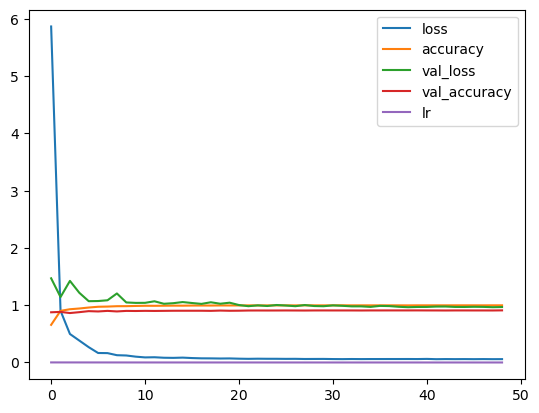

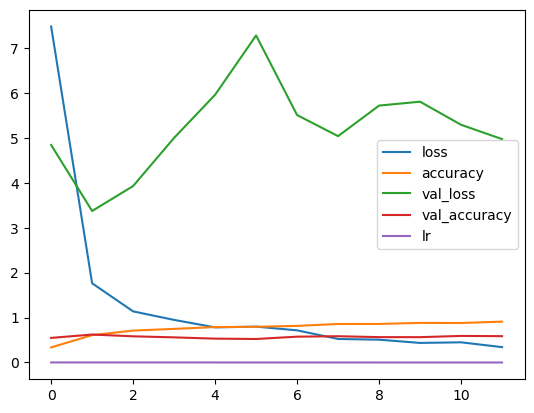

In [24]:
for model_name in models:
    history = models[model_name]["history"]
    if history != None: 
        history_df = pd.DataFrame(history.history)
        history_df.loc[:, :].plot()

# Run Tests On All Models

- We tested all models on all versions of the test data (normal, gaussian blur, moption blur, bad exposure, jpg compression, gausian noise).

## Load All Test Data Sets

- First all test data (normal, gaussian blur, moption blur, bad exposure, jpg compression, gausian noise) sets have to be loaded.

In [25]:
all_test_sets = {
    "normal_test_data": {"load": True},
    "gblur_test_data": {"load": False},
    "gnoise_test_data": {"load": False}, 
    "expo_test_data": {"load": False}, 
    "mblur_test_data": {"load": True},
    "jpgc_test_data": {"load": False}
    }

In [26]:
for test_set in all_test_sets:
    if all_test_sets[test_set]["load"]:
        test_data_dir = f"./data/test/{test_set}"
        all_test_sets[test_set]["data"] = tf.keras.utils.image_dataset_from_directory(
            test_data_dir,
            seed=123,
            image_size=(image_height, image_width),
            batch_size=batch_size
            )
all_test_sets

Found 1715 files belonging to 12 classes.
Found 1715 files belonging to 12 classes.


{'normal_test_data': {'load': True,
  'data': <BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>},
 'gblur_test_data': {'load': False},
 'gnoise_test_data': {'load': False},
 'expo_test_data': {'load': False},
 'mblur_test_data': {'load': True,
  'data': <BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>},
 'jpgc_test_data': {'load': False}}

## Run Tests

- Each model evaluates each dataset and the results are saved. 

In [27]:
# Load Model
for model_name in models:
    if models[model_name]["test"]:
         # clear model
        model = None
        print(f"> Loading {model_name}")
        model_dir = f"./models/{model_name}"
        model = tf.keras.models.load_model(model_dir)
        model.load_weights(f"{model_dir}/checkpoints/")

        # Run Tests     
        models[model_name]["test_results"] = {}
        for test_set in all_test_sets:
            if all_test_sets[test_set]["load"]:
                print(f"> Testing {model_name} on {test_set}")
                models[model_name]["test_results"][test_set] = model.evaluate(all_test_sets[test_set]["data"])

> Loading normal_model
> Testing normal_model on normal_test_data
7/7 [==============================] - 12s 285ms/step - loss: 1.1071 - accuracy: 0.8997
> Testing normal_model on mblur_test_data
7/7 [==============================] - 5s 285ms/step - loss: 3.7644 - accuracy: 0.6414
> Loading mblur_model


> Testing mblur_model on normal_test_data
7/7 [==============================] - 12s 287ms/step - loss: 3.9555 - accuracy: 0.5802
> Testing mblur_model on mblur_test_data
7/7 [==============================] - 5s 284ms/step - loss: 2.4974 - accuracy: 0.6385


{'normal_test_data': [1.1071345806121826, 0.8997083902359009], 'mblur_test_data': [3.7643988132476807, 0.6413993835449219]}


KeyError: 'test_results'

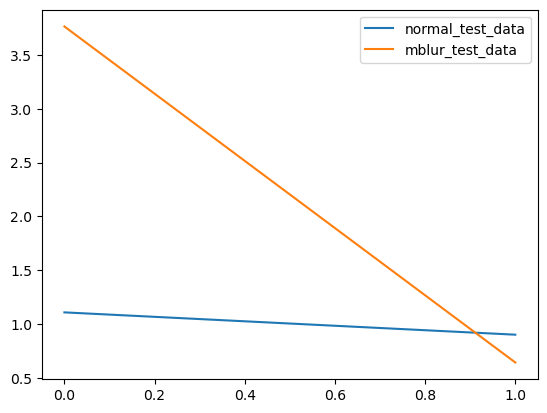

In [37]:
for model_name in models:
    test_results = models[model_name]["test_results"]
    print(test_results)
    
    if test_results != None: 
        result_df = pd.DataFrame(test_results)
        result_df.loc[:,:].plot()